# Cancer Tissue Detection using CNN


#### Installing Required libraries

### Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.


In [10]:
#Step1 Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed here

## **Step 1.2 Import the neccessary packages. Please refer to the section, Importing the packages in the book for further details. **

In [8]:
#refer to book for correct version of package and import here

In [ ]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)



# **Step 2.1 - Load the dataset- Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and steps to import it. **

In [11]:
#refer to section "Collecting the dataset and copy code here "


There is a separate csv file which contains only the labels. Let's read the dataset and see the head of the dataframe in pandas

In [ ]:
df_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
df_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 130908 normal cases (0) and and 89117 abnormal (cancerous) cases (1) 

*   List item
*   List item

which is not highly unbalanced. 

In [ ]:
print('No. of images in training dataset: ', len(os.listdir("histopathologic-cancer-detection/train")))
print('No. of images in testing dataset: ', len(os.listdir("histopathologic-cancer-detection/test")))

No. of images in training dataset:  220025
No. of images in testing dataset:  57458


This is a huge dataset which requires a lot of compute time and resources so for the purpose of learning our first basic image classification model, we will downsample it to 5000 images and then split it into training and testing dataset.

In [ ]:
# Setting seed to make the results replicable
np.random.seed(0)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

In [ ]:
selected_image_list[0]

'7a52bc2ef4fb067330f04dd43e6b38c2051126db.tif'

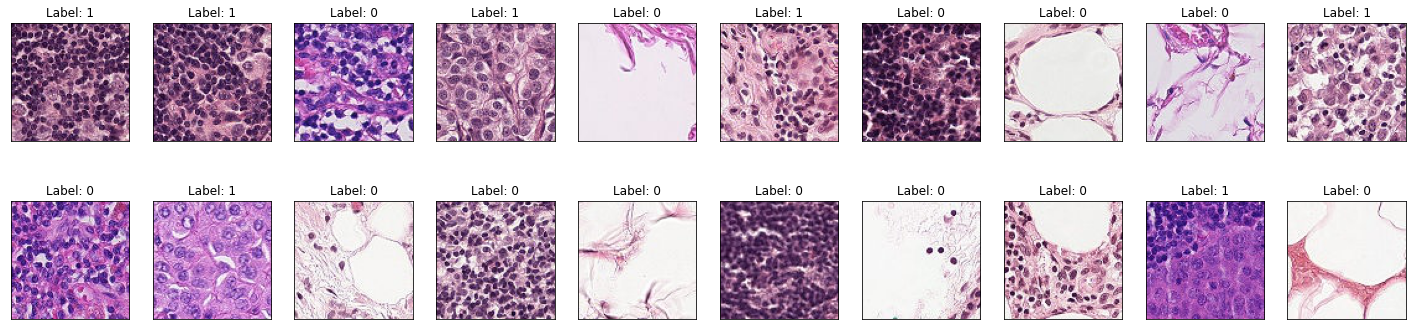

In [ ]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = df_labels.loc[df_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
train_idx = selected_image_list[:8000]
test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(train_idx))
print("Number of images in the downsampled testing dataset: ", len(test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


### Processing the dataset
The following information has been provided on the Kaggle and the Github where the dataset is hosted - "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image."

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
 #cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
pwd

'/content'

In [ ]:
import os

In [ ]:
#os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')

In [ ]:
os.mkdir('/content/histopathologic-cancer-detection/train_dataset/')
for fname in train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/train_dataset/")))


No. of images in downsampled training dataset:  7847


In [ ]:
os.mkdir('/content/histopathologic-cancer-detection/test_dataset/')
for fname in test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/histopathologic-cancer-detection/test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("/content/histopathologic-cancer-detection/test_dataset/")))

No. of images in downsampled testing dataset:  1989


In [ ]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [ ]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = df_labels.loc[df_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [ ]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,a31e99f1b06d1ed5f9f0306a1d453385659ab32b,0
1,c8d9799680419ede996570d7610da43136da6e7d,1
2,568b66ad4616f94d204b6df2ab15289b4af76976,1
3,f3509bad70373d29ec2c4d7221d4e7ef4f0f97a5,0
4,ee33ffaf0ec4d1a3c71d92a7d926266cc56c5180,1


In [ ]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

Pytorch lightning expects data to be in folders with the classes. We cannot use the DataLoader module directly when all train images are in one folder without subfolders. So, we will write our custom function to carry out the loading. 


In [ ]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [ ]:
%%time
# Load train data 
train_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/train_dataset/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 10.4 ms, sys: 1.99 ms, total: 12.4 ms
Wall time: 13.5 ms


In [ ]:
test_set = LoadCancerDataset(data_folder='/content/histopathologic-cancer-detection/test_dataset/', 
                         transform=data_T_test, dict_labels=img_label_dict)


In [ ]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

In [ ]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [ ]:
model = CNNImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------

Training: 0it [00:00, ?it/s]

In [ ]:
ckpt_dir = "/content/gdrive/MyDrive/Colab Notebooks/cnn"
# ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CNNImageClassifier()
trainer = pl.Trainer(
    default_root_dir=ckpt_dir,
                     gpus=-1,
                    #  progress_bar_refresh_rate=30,
                        # callbacks=[ckpt_callback],
                        log_every_n_steps=25,
                        max_epochs=500)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Tot

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(test_dataloaders=test_dataloader)

In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:
test_preds = pd.DataFrame({'imgs': test_set.list_image_files, 'labels':test_set.labels,  'preds': preds})


In [ ]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])


In [ ]:
test_preds.head()

In [ ]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

In [ ]:
test_preds.head()

In [ ]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]